# 1: Data collection and preprocessing

TODO Introduction

To start, we'll import all the packages we're going to be using.

In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import visualisations as vis
import matplotlib.pyplot as plt

/home/graeme/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## General Elections

TODO

OLD: The first data processing we'll carry out is amalgamating the results of the last 4 general elections and the 2016 EU membership referendum for each constituency taken from the boundaries introduced in the 2010 general election. Most of the constituency leave vote share data comes from estimates made by Chris Hanretty. After merging, we'll end up with a single DataFrame called ge2010_2019_df. This is the primary table we'll use throughout our analysis from this point onwards. Each constituency is represented by a single row in this DataFrame.

In [2]:
# Election results
columns = ["ons_id", "constituency_name", "county_name", "region_name", "country_name", "result", 
           "first_party", "second_party", "electorate", "valid_votes", "invalid_votes", "con", 
           "lab", "ld", "brexit", "ukip", "green", "snp", "pc", "dup", "sf", "sdlp", "uup", "alliance", 
           "other", "turnout_const", "turnout_reg"]

ge2019_df = pd.read_csv("csvs/ge2019.csv").filter(columns).add_prefix("2019_")

columns = [col for col in  columns if col not in ["constituency_name", "county_name", "region_name", "country_name"]]
ge2019_df.rename({"2019_ons_id": "ons_id", "2019_constituency_name": "constituency_name", "2019_county_name": "county_name", "2019_region_name": "region_name", "2019_country_name": "country_name"}, axis=1, inplace=True)

ge2017_df = pd.read_csv("csvs/ge2017.csv").filter(columns).add_prefix("2017_")
ge2015_df = pd.read_csv("csvs/ge2015.csv").filter(columns).add_prefix("2015_")
ge2010_df = pd.read_csv("csvs/ge2010.csv").add_prefix("2010_")
ge2010_df = ge2010_df.fillna(0)

ge2010_2019_df = pd.merge(ge2019_df, ge2017_df, left_on="ons_id", right_on="2017_ons_id")
ge2010_2019_df = pd.merge(ge2010_2019_df, ge2015_df, left_on="ons_id", right_on="2015_ons_id")
ge2010_2019_df = pd.merge(ge2010_2019_df, ge2010_df, left_on="ons_id", right_on="2010_ons_id")

ge2010_2019_df.drop(inplace=True, axis=1, labels=["2017_ons_id", "2015_ons_id", "2010_ons_id"])

ge2010_2019_df.head()

,ons_id,constituency_name,county_name,region_name,country_name,2019_result,2019_first_party,2019_second_party,2019_electorate,2019_valid_votes,...,2010_green,2010_snp,2010_pc,2010_dup,2010_sf,2010_sdlp,2010_uup,2010_alliance,2010_other,2010_valid_votes
0,W07000049,Aberavon,West Glamorgan,Wales,Wales,Lab hold,Lab,Con,50750,31598,...,0.0,0.0,2198.0,0.0,0.0,0.0,0.0,0.0,2753.0,30958
1,W07000058,Aberconwy,Clwyd,Wales,Wales,Con hold,Con,Lab,44699,31865,...,0.0,0.0,5341.0,0.0,0.0,0.0,0.0,0.0,137.0,29966
2,S14000001,Aberdeen North,Scotland,Scotland,Scotland,SNP hold,SNP,Con,62489,37413,...,0.0,8385.0,0.0,0.0,0.0,0.0,0.0,0.0,903.0,37701
3,S14000002,Aberdeen South,Scotland,Scotland,Scotland,SNP gain from Con,SNP,Con,65719,45638,...,413.0,5102.0,0.0,0.0,0.0,0.0,0.0,0.0,667.0,43034
4,S14000003,Airdrie and Shotts,Scotland,Scotland,Scotland,SNP hold,SNP,Lab,64011,39772,...,0.0,8441.0,0.0,0.0,0.0,0.0,0.0,0.0,528.0,35849


In 2010, constituency and boundary changes for England, Scotland and Wales were implemented. The same happened for Scotland in 2005. For example, some constituencies completed disappeared, others were merged into several new constituencies and some had their boundaries slightly changed while being completely renamed. This makes analysing longer term trends harder as some constituencies have only exisited in their current makeup since 2010. Without doing anything too fancy, we're going to do our best to get as many constituencies as possible lined up with 1997 and 2019 data. In the future, I may revisit this to do something more fancy and accurate.

In [3]:
ge_1918_2019_df = pd.read_csv("csvs/ge1918_2019.csv")
ge_1918_2019_df.rename({"constituency": "constituency_name", "country/region": "region_name"}, axis=1, inplace=True)
ge_1918_2019_df["constituency_name"] = ge_1918_2019_df["constituency_name"].str.replace("&", "AND")

# TODO: could be optimised and fix SettingWithCopyWarning
# Calculate snp and pc components
def convert_natSW_to_snp_pc(ge_df):
    snp = []
    pc = []
    for index, row in ge_df.iterrows():
        if (row["region_name"] == "Scotland"):
            snp.append(row["natSW"])
            pc.append(np.nan)
        elif (row["region_name"] == "Wales"):
            snp.append(np.nan)
            pc.append(row["natSW"])
        else:
            snp.append(np.nan)
            pc.append(np.nan)
    ge_df["snp"] = snp
    ge_df["pc"] = pc
    ge_df.drop(inplace=True, axis=1, labels=["natSW"])
    return ge_df

ge2005_df = convert_natSW_to_snp_pc(ge_1918_2019_df[ge_1918_2019_df["election"] == "2005"]).add_prefix("2005_")
ge2001_df = convert_natSW_to_snp_pc(ge_1918_2019_df[ge_1918_2019_df["election"] == "2001"]).add_prefix("2001_")
ge1997_df = convert_natSW_to_snp_pc(ge_1918_2019_df[ge_1918_2019_df["election"] == "1997"]).add_prefix("1997_")

# Change constituency names for 2010-2019 to be all uppercase and replace all &s with ANDs
ge2010_2019_df["constituency_name"] = ge2010_2019_df["constituency_name"].str.upper()
ge2010_2019_df["constituency_name"] = ge2010_2019_df["constituency_name"].str.replace("&", "AND")
    

ge1997_2001_df = pd.merge(ge1997_df, ge2001_df, left_on="1997_constituency_id", right_on="2001_constituency_id")

/home/graeme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/graeme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/graeme/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In 2005, a number of Scottish constituencies changed but some stayed the same, or at least their name did. Below, we'll try to match the pre-2005 scottish constituencies that didn't change their name entirley with their 2005 counterparts.

In [4]:
# We'll start by isolating the english, welsh and irish constituencies that kept the same ids as they did not change in 2005
ge1997_2005_eng_wales_ni_df = pd.merge(
    ge1997_2001_df[ge1997_2001_df["2001_region_name"] != "Scotland"], 
    ge2005_df[ge2005_df["2005_region_name"] != "Scotland"],
    left_on="2001_constituency_id",
    right_on="2005_constituency_id")

# TODO: optimise below
# We're going to attempt to match up each of the pre-2005 Scottish constituencies with their 2005 conunterparts
ge1997_2001_scotland_df = ge1997_2001_df[ge1997_2001_df["2001_region_name"] == "Scotland"]
ge2005_scotland_df = ge2005_df[ge2005_df["2005_region_name"] == "Scotland"]

# We'll use fuzzywuzzy to account for ordering differences of constituency names 
def find_2001_2005_scottish_con_pairs(row):
    con_2001 = row["2001_constituency_name"]
    cons_2005 = set(ge2005_scotland_df["2005_constituency_name"].values)
    for con_2005 in cons_2005:
        if (fuzz.token_sort_ratio(con_2001, con_2005) == 100):
            row["2001_constituency_name"] = con_2005
            break
    return row

ge1997_2001_scotland_df = ge1997_2001_scotland_df.apply(find_2001_2005_scottish_con_pairs, axis=1)

ge1997_2005_scotland_df = pd.merge(
    ge2005_scotland_df,
    ge1997_2001_scotland_df,
    left_on="2005_constituency_name",
    right_on="2001_constituency_name",
    how="left"
)

ge1997_2005_df = pd.concat([ge1997_2005_eng_wales_ni_df ,ge1997_2005_scotland_df])
ge1997_2005_df.drop(inplace=True, axis=1, labels=['1997_constituency_id', '1997_constituency_name', '1997_region_name', '1997_boundary_set',
                                                    '2001_constituency_id', '2001_constituency_name', '2001_region_name', '2001_boundary_set'])

Now we'll attempt to do something similar for the 2010 constituency changes in England, Wales and Northern Ireland.

In [5]:
ge1997_2019_scotland_df = pd.merge(
    ge1997_2005_df,
    ge2010_2019_df,
    left_on="2005_constituency_id",
    right_on="ons_id"
)

# TODO: optimise below
# We're going to attempt to match up each of the pre-2010 constituencies with their 2010 conunterparts
ge1997_2005_not_scotland_df = ge1997_2005_df[ge1997_2005_df["2005_region_name"] != "Scotland"]
ge2010_2019_not_scotland_df = ge2010_2019_df[ge2010_2019_df["county_name"] != "Scotland"]

# We'll use fuzzywuzzy to account for ordering differences of constituency names 
def find_2005_2010_con_pairs(row):
    con_2005 = row["2005_constituency_name"]
    cons_2010 = set(ge2010_2019_not_scotland_df["constituency_name"].values)
    for con_2010 in cons_2010:
        if (fuzz.token_sort_ratio(con_2005, con_2010) == 100):
            row["2005_constituency_name"] = con_2010
            break
    return row

ge1997_2005_not_scotland_df = ge1997_2005_not_scotland_df.apply(find_2005_2010_con_pairs, axis=1)

ge1997_2019_not_scotland_df = pd.merge(
    ge2010_2019_not_scotland_df,
    ge1997_2005_not_scotland_df,
    left_on="constituency_name",
    right_on="2005_constituency_name",
    how="left"
)

ge1997_2019_df = pd.concat([ge1997_2019_scotland_df ,ge1997_2019_not_scotland_df])
ge1997_2019_df.drop(inplace=True, axis=1, labels=["1997_election","2001_election", "2005_election", "2005_constituency_name"])

Fix region names

In [6]:
ge1997_2001_df.loc[ge1997_2001_df["1997_region_name"] == "Eastern", ["1997_region_name"]] = "east"
ge1997_2001_df.loc[ge1997_2001_df["2001_region_name"] == "Eastern", ["2001_region_name"]] = "east"
ge2005_df.loc[ge2005_df["2005_region_name"] == "Eastern", "2005_region_name"] = "east"
ge2005_df["2005_region_name"].value_counts()

South East                  83
North West                  76
London                      74
West Midlands               59
Scotland                    59
Yorkshire and the Humber    56
east                        56
South West                  51
East Midlands               44
Wales                       40
North East                  30
Northern Ireland            18
Name: 2005_region_name, dtype: int64

## 2016 EU membership referendum

In [7]:
eu_ref_results_df = pd.read_csv("csvs/euref.csv").filter(["ons_id", "leave_share"])
constits_df = pd.merge(ge1997_2019_df, eu_ref_results_df, on="ons_id")

## British Election Study survey data

In [8]:
bes_w6_df = pd.read_csv("csvs/bes_datasets/BES_W6.csv")
bes_w6_df.rename({"generalElectionVote": "general_election_vote"}, axis=1, inplace=True)
# wt
bes_w6_df.loc[bes_w6_df["wt"] == " ", "wt"] = 0
bes_w6_df["wt"] = pd.to_numeric(bes_w6_df["wt"])
# p_past_vote_2010
bes_w6_df.loc[bes_w6_df["p_past_vote_2010"] == " ", "p_past_vote_2010"] = "Didn't vote"
# general_election_vote
bes_w6_df.loc[bes_w6_df["general_election_vote"] == " ", "general_election_vote"] = "Didn't vote"
# country
bes_w6_df["country"] = bes_w6_df["country"].map({
    "1": "England",
    1: "England",
    "2": "Scotland",
    2: "Scotland",
    "3": "Wales",
    3: "Wales"
})

/home/graeme/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (427,428,430) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## House Prices

In [20]:
# Doesn't work properly
constits_house_prices = pd.read_csv("csvs/constituency_data/house_prices.csv")
constits_house_prices = constits_house_prices.rename({"ONSConstID": "ons_id", "HouseConstMedianPrice": "constituency_median_house_price", "HouseRegionMedianPrice": "region_median_house_price"}, axis=1)
constits_house_prices = constits_house_prices.filter(["ons_id", "2019_constituency_median_house_price", "2019_region_median_house_price", "DateOfDataset"])
constits_house_prices = constits_house_prices[constits_house_prices["DateOfDataset"] == "2015-06-30"]
constits_house_prices["constituency_median_house_price"] = pd.to_numeric(constits_house_prices["constituency_median_house_price"], errors="coerce")
constits_house_prices["region_median_house_price"] = pd.to_numeric(constits_house_prices["region_median_house_price"], errors="coerce")
constits_house_prices["constituency_median_house_price"].value_counts(dropna=False)

NaN         77
165000.0    14
120000.0    13
125000.0     9
200000.0     8
            ..
342250.0     1
191000.0     1
269500.0     1
92000.0      1
128000.0     1
Name: constituency_median_house_price, Length: 316, dtype: int64

In [ ]:
constits_df = pd.merge(constits_df, constits_house_prices[constits_house_prices["DateOfDataset"] == "2015-06-30"], on="ons_id")
constits_df.drop(inplace=True, axis=1, labels=["DateOfDataset"])

TypeError: cannot perform reduce with flexible type

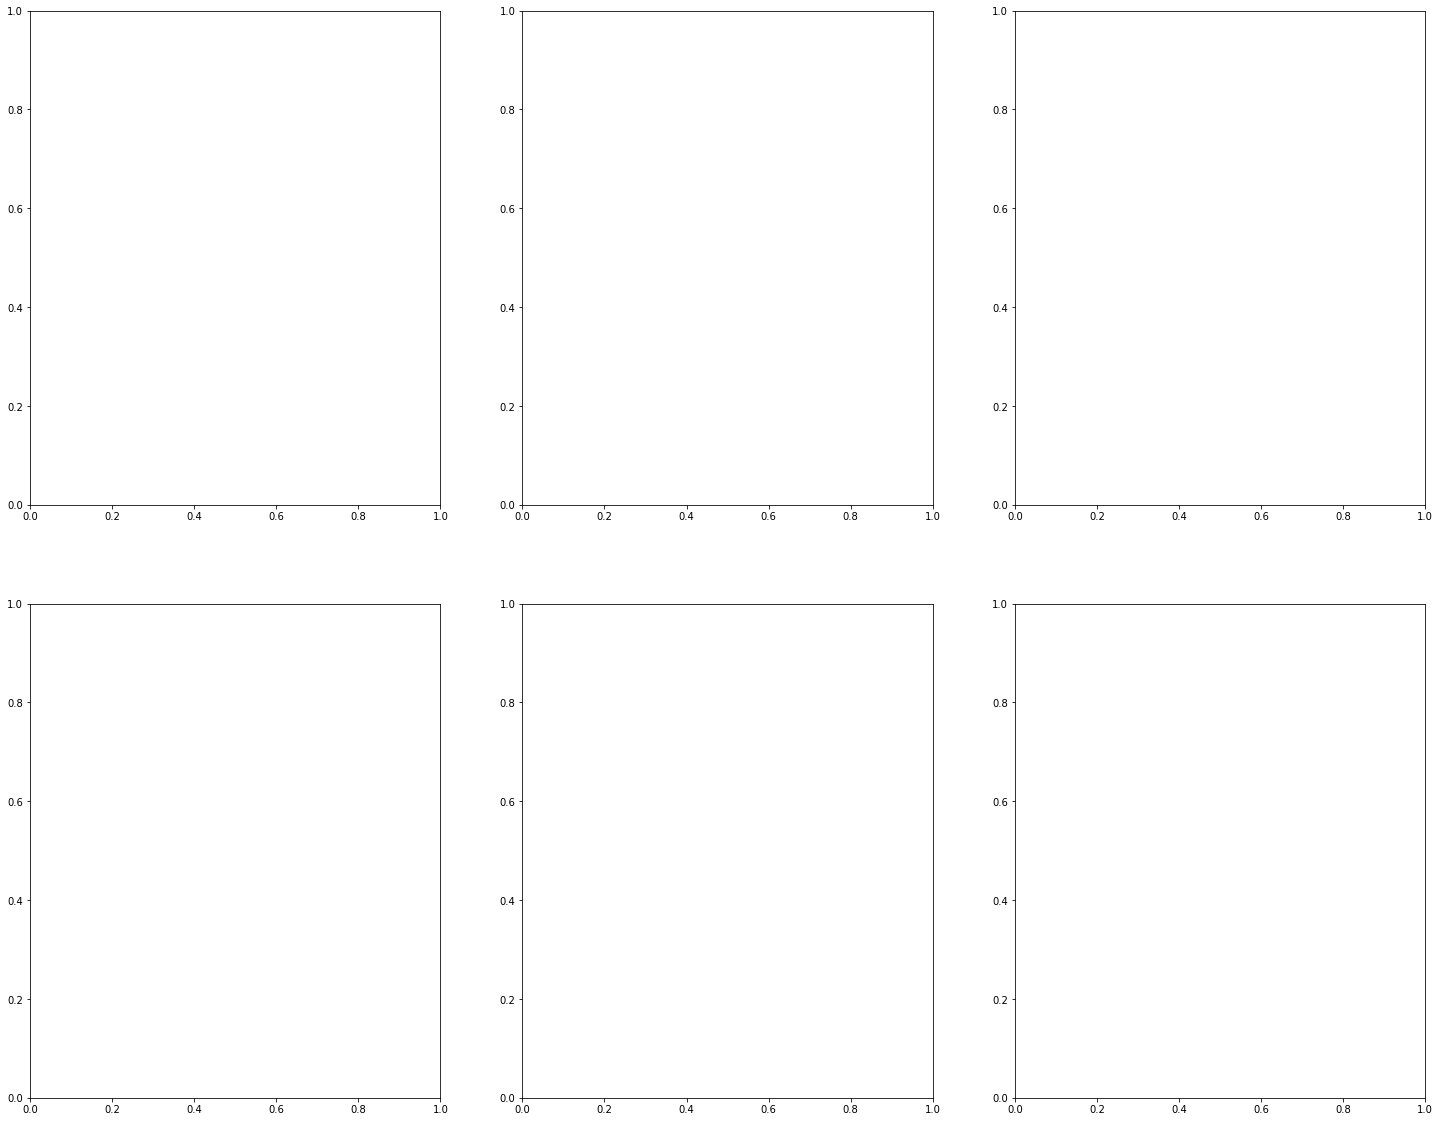

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(25, 20))
vis.create_continous_constit_map(constits_df, "constituency_median_house_price", fig=fig, ax=axes[0][0], title="level4+", colour_map="Blues")

## Educational attainment

In [13]:
constits_education = pd.read_csv("csvs/constituency_data/education_levels.csv")
constits_df = pd.merge(constits_df, constits_education, on="ons_id")

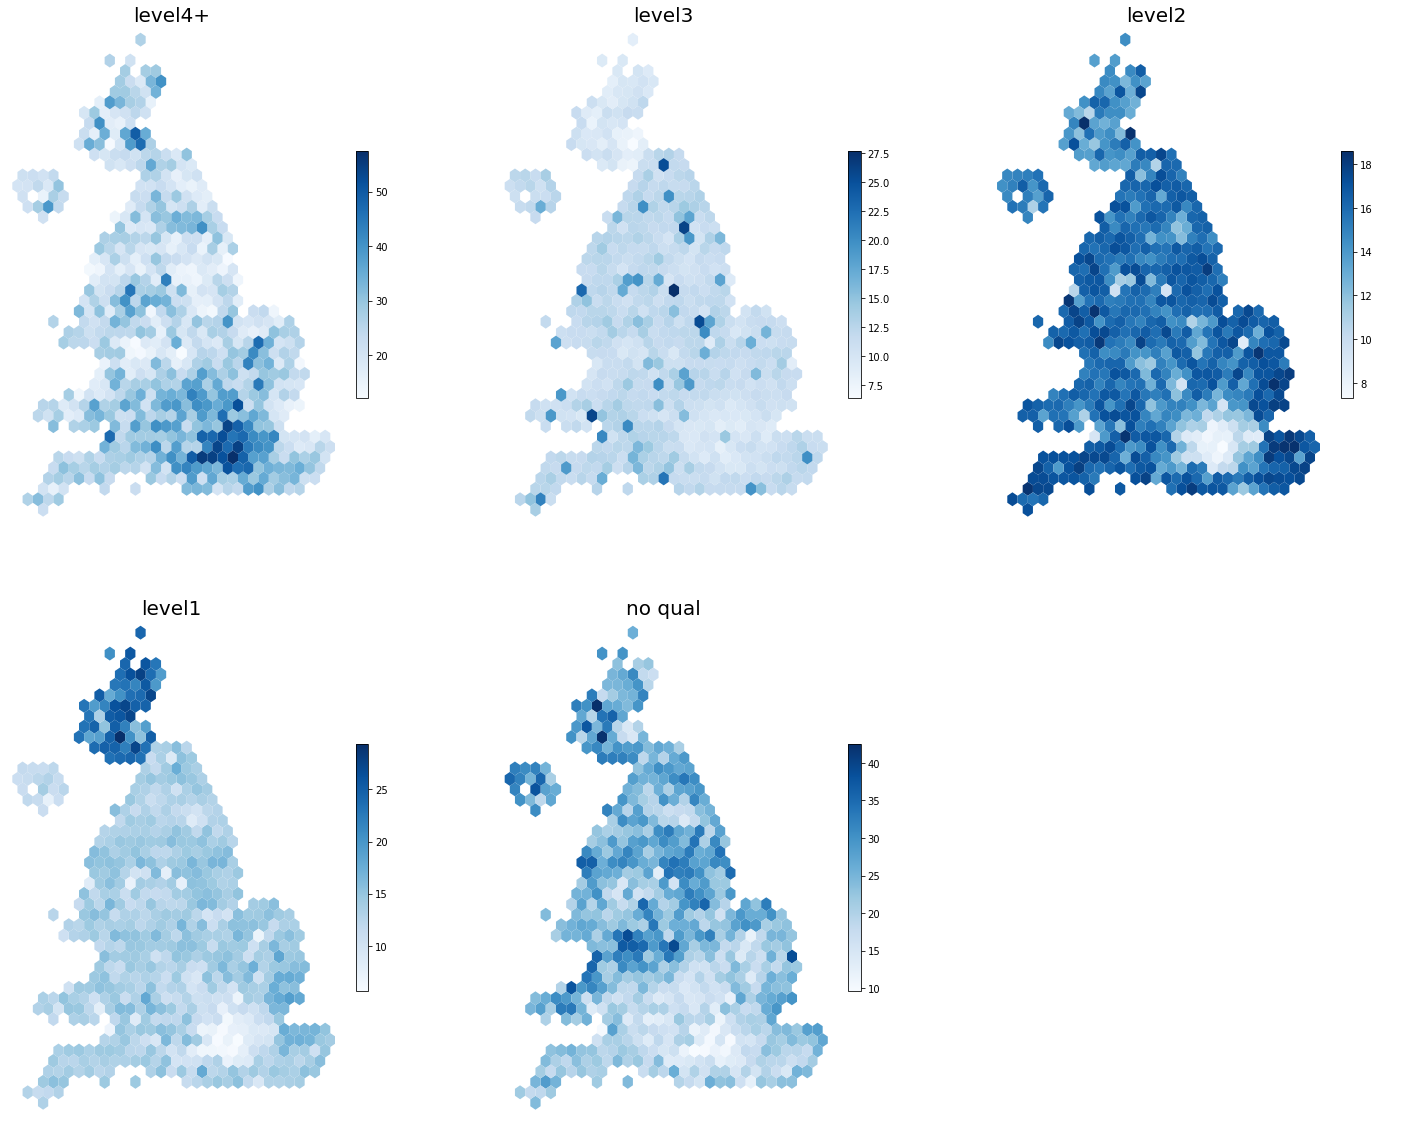

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(25, 20))
vis.create_continous_constit_map(constits_df, "level_4_plus", fig=fig, ax=axes[0][0], title="level4+", colour_map="Blues")
vis.create_continous_constit_map(constits_df, "level_3_highest", fig=fig, ax=axes[0][1], title="level3", colour_map="Blues")
vis.create_continous_constit_map(constits_df, "level_2_highest", fig=fig, ax=axes[0][2], title="level2", colour_map="Blues")
vis.create_continous_constit_map(constits_df, "level_1_highest", fig=fig, ax=axes[1][0], title="level1", colour_map="Blues")
vis.create_continous_constit_map(constits_df, "no_qualifications_highest", fig=fig, ax=axes[1][1], title="no qual", colour_map="Blues")
axes[1][2].axis("off")
print()

To finish, we'll write our final datasets to csvs ready for exploration and analysis. We're also going to convert some columns to lower case to make dealing with them in the future easier.

In [34]:
def convert_cols_to_lowercase(df):
    for col in df.columns:
        if df[col].dtype == np.object and "id" not in col:
            df[col] = df[col].str.lower()
    return df

ge1997_2001_df = convert_cols_to_lowercase(ge1997_2001_df)
ge2005_df = convert_cols_to_lowercase(ge2005_df)
constits_df = convert_cols_to_lowercase(constits_df)

ge1997_2001_df.to_csv("csvs/final_datasets/ge1997_2001.csv", index=False)
ge2005_df.to_csv("csvs/final_datasets/ge2005.csv", index=False)
constits_df.to_csv("csvs/final_datasets/constits.csv", index=False)
bes_w6_df.to_csv("csvs/final_datasets/bes_w6.csv", index=False)

NameError: name 'bes_w6_df' is not defined